In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
#Ricordiamoci di cambiare il dataset da consegnare a 200k
!ls pubmed-rct/PubMed_200k_RCT

dev.txt  test.txt  train.7z


In [ ]:
!pip install py7zr

In [ ]:
import py7zr
with py7zr.SevenZipFile('/content/pubmed-rct/PubMed_200k_RCT/train.7z', mode='r') as z:
    z.extractall(path="/content/pubmed-rct/PubMed_200k_RCT")

In [ ]:
data_dir = "pubmed-rct/PubMed_200k_RCT/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_200k_RCT/train.txt',
 'pubmed-rct/PubMed_200k_RCT/test.txt',
 'pubmed-rct/PubMed_200k_RCT/train.7z',
 'pubmed-rct/PubMed_200k_RCT/dev.txt']

### Preprocessing ###

In [ ]:
def get_lines(filename):
  
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [ ]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 6.25 s, sys: 1.03 s, total: 7.28 s
Wall time: 10.3 s


(2211861, 28932, 29493)

In [ ]:
train_samples[:3]

[{'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_lines': 10}]

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


In [ ]:
"""from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)"""

Mounted at /content/gdrive


In [ ]:
"""train_df.to_csv("/content/gdrive/MyDrive/Text Mining/Saved Models/train_df")
val_df.to_csv("/content/gdrive/MyDrive/Text Mining/Saved Models/val_df")
test_df.to_csv("/content/gdrive/MyDrive/Text Mining/Saved Models/test_df")"""

In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

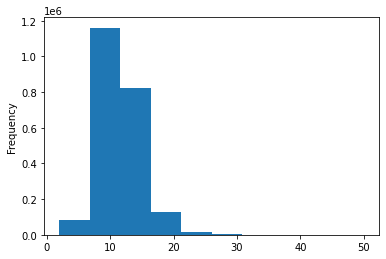

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(2211861, 28932, 29493)

In [ ]:
train_sentences[:5]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .']

In [ ]:
"""import pickle

with open("/content/gdrive/MyDrive/Text Mining/Saved Models/train_sentences_NoStopWord", "wb") as fp:
  pickle.dump(train_sentences, fp)
with open("/content/gdrive/MyDrive/Text Mining/Saved Models/val_sentences_NoStopWord", "wb") as fp:
  pickle.dump(val_sentences, fp)
with open("/content/gdrive/MyDrive/Text Mining/Saved Models/test_sentences_NoStopWord", "wb") as fp:
  pickle.dump(test_sentences, fp)"""

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(256).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(256).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(256).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## First Model 

### Bi-Grams

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer(min_df=3, ngram_range=(2, 2),use_idf=True)),
  ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [ ]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.8111088068574589

In [ ]:
from sklearn.metrics import accuracy_score

Y_test_pred = model_0.predict(test_sentences)
print(accuracy_score(test_labels_encoded, Y_test_pred))

0.8115824093852778


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded, Y_test_pred))

              precision    recall  f1-score   support

           0       0.72      0.45      0.56      2663
           1       0.72      0.75      0.73      4426
           2       0.85      0.92      0.88      9751
           3       0.72      0.53      0.61      2377
           4       0.85      0.90      0.87     10276

    accuracy                           0.81     29493
   macro avg       0.77      0.71      0.73     29493
weighted avg       0.81      0.81      0.80     29493



### Tri-Grams

In [ ]:
model_1 = Pipeline([
  ("tf-idf", TfidfVectorizer(min_df=3, ngram_range=(2, 3),use_idf=True)),
  ("clf", MultinomialNB())
])

model_1.fit(X=train_sentences, 
            y=train_labels_encoded);

In [ ]:
model_1.score(X=val_sentences,
              y=val_labels_encoded)

0.8123876676344532

In [ ]:
from sklearn.metrics import accuracy_score

Y_test_pred = model_1.predict(test_sentences)
print(accuracy_score(test_labels_encoded, Y_test_pred))

0.8118875665412132


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded, Y_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.44      0.55      2663
           1       0.72      0.73      0.72      4426
           2       0.85      0.92      0.88      9751
           3       0.72      0.55      0.62      2377
           4       0.84      0.90      0.87     10276

    accuracy                           0.81     29493
   macro avg       0.77      0.71      0.73     29493
weighted avg       0.81      0.81      0.80     29493



In [ ]:
from sklearn.svm import LinearSVC

model_2 = Pipeline([
  ("tf-idf", TfidfVectorizer(min_df=3, ngram_range=(2, 3),use_idf=True)),
  ("clf", LinearSVC())
])

model_2.fit(X=train_sentences, 
            y=train_labels_encoded);

In [ ]:
model_2.score(X=val_sentences,
              y=val_labels_encoded)

0.8433222729158025

In [ ]:
from sklearn.metrics import accuracy_score

Y_test_pred = model_2.predict(test_sentences)
print(accuracy_score(test_labels_encoded, Y_test_pred))

0.8417251551215542


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded, Y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.60      0.63      2663
           1       0.79      0.77      0.78      4426
           2       0.88      0.93      0.91      9751
           3       0.72      0.64      0.68      2377
           4       0.89      0.90      0.89     10276

    accuracy                           0.84     29493
   macro avg       0.79      0.77      0.78     29493
weighted avg       0.84      0.84      0.84     29493



In [ ]:
"""import joblib

#save your model or results
joblib.dump(model_2, '/content/gdrive/MyDrive/Text Mining/Saved Models/LinearSVC')"""

['/content/gdrive/MyDrive/Text Mining/Saved Models/LinearSVC']

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

## Universal Sentence Encoder Embedding 

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder") # Possibile implementazione di bert per gli embeddings

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional, Reshape

### LSTM

In [ ]:
input = layers.Input(shape=(), dtype=tf.string)
x = tf_hub_embedding_layer(input)
x = Reshape((-1, 512))(x)
x = SpatialDropout1D(0.2)(x)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(128, return_sequences=False)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=input,
                        outputs=output)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 reshape (Reshape)           (None, 1, 512)            0         
                                                                 
 spatial_dropout1d (SpatialD  (None, 1, 512)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 1, 128)            328192    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

class TrainingPlot(keras.callbacks.Callback):

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))

        N = np.arange(0, len(self.losses))
        
        # Plot train loss, train acc, val loss and val acc against epochs passed
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.plot(N, self.losses, label = "train_loss")
        ax2.plot(N, self.acc, label = "train_acc")
        ax1.plot(N, self.val_losses, label = "val_loss")
        ax2.plot(N, self.val_acc, label = "val_acc")
        ax1.set_title("Loss")
        ax2.set_title("Accuracy")
        ax1.set(xlabel='Epoch', ylabel='Loss')
        ax2.set(xlabel='Epoch', ylabel='Acc')
        fig.tight_layout()
        ax1.legend()
        ax2.legend()
        # plt.savefig('output/Epoch-{}.png'.format(epoch))
        plt.show()
        
training_history = TrainingPlot()

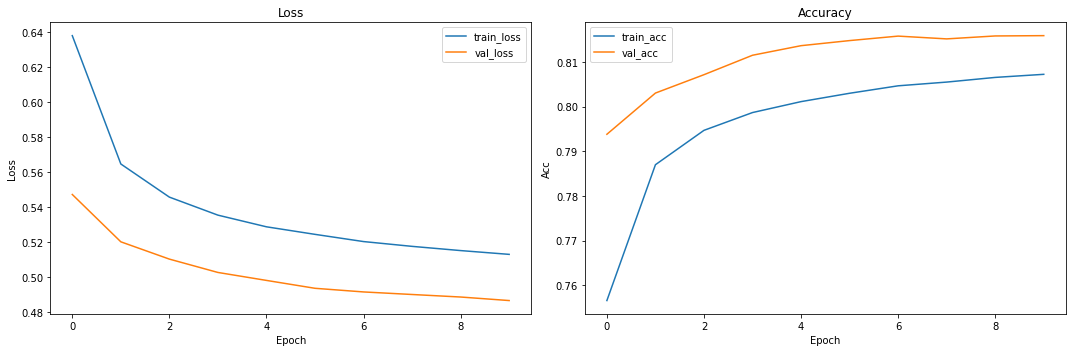

8641/8641 [==============================] - 259s 30ms/step - loss: 0.5131 - accuracy: 0.8072 - val_loss: 0.4868 - val_accuracy: 0.8159


In [ ]:
model_2.fit(train_dataset,
            epochs=10,
            validation_data=valid_dataset,
            callbacks = [training_history]
            )

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
model_2.save('/content/gdrive/MyDrive/Text Mining/Saved Models/LSTM_Model_StopWords')

In [ ]:
from sklearn.metrics import accuracy_score

Y_test_pred = model_2.predict(test_sentences)
y_test_pred = Y_test_pred.argmax(1)
print(accuracy_score(test_labels_encoded, y_test_pred))

922/922 [==============================] - 9s 9ms/step
0.818465398569152


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded, y_test_pred))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      2663
           1       0.75      0.71      0.73      4426
           2       0.88      0.90      0.89      9751
           3       0.74      0.59      0.66      2377
           4       0.86      0.89      0.88     10276

    accuracy                           0.82     29493
   macro avg       0.77      0.74      0.75     29493
weighted avg       0.82      0.82      0.82     29493



### Bi-LSTM

In [ ]:
input = layers.Input(shape=(), dtype=tf.string)
x = tf_hub_embedding_layer(input)
x = Reshape((-1, 512))(x)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model_3 = tf.keras.Model(inputs=input,
                        outputs=output)

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 reshape_3 (Reshape)         (None, 1, 512)            0         
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 1, 512)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 1, 256)           656384    
 l)                                                              
                                                           

In [ ]:
model_3.fit(train_dataset,
            epochs=2,
            validation_data=valid_dataset,
            callbacks = [training_history]
            )

In [ ]:
from sklearn.metrics import accuracy_score

Y_test_pred = model_3.predict(test_sentences)
y_test_pred = Y_test_pred.argmax(1)
print(accuracy_score(test_labels_encoded, y_test_pred))

922/922 [==============================] - 12s 11ms/step
0.8215169701285051


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded, y_test_pred))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61      2663
           1       0.72      0.75      0.74      4426
           2       0.88      0.90      0.89      9751
           3       0.71      0.63      0.67      2377
           4       0.88      0.88      0.88     10276

    accuracy                           0.82     29493
   macro avg       0.76      0.75      0.76     29493
weighted avg       0.82      0.82      0.82     29493



In [ ]:
#model_3.save('/content/gdrive/MyDrive/Text Mining/Saved Models/Bi-LSTM_Model_StopWords')